<a href="https://colab.research.google.com/github/albinjames/CERN-Code-2018/blob/master/Workshop_Data_Engineer_V%C3%A9lib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark pyspark

tar: spark-2.4.5-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now
     |████████████████████████████████| 204.2MB 74kB/s 
     |████████████████████████████████| 204kB 45.9MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [ ]:
import findspark

from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext

findspark.init()
sc = SparkContext("local")
sql_c = SQLContext(sc)

## Importation des données brutes

Nous allons récupérer les données brutes contenant les informations de chaque station.

Ces données ont été récupérés pour chaque station et à chaque minute. Il faut donc **agréger** l'information par heure et pour chaque station.

In [ ]:
!for i in {0..6}; do curl -O https://velib.nocle.fr/dump/2019-03-1$i-data.db -k; done;

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79.0M  100 79.0M    0     0  8879k      0  0:00:09  0:00:09 --:--:-- 10.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79.3M  100 79.3M    0     0  7732k      0  0:00:10  0:00:10 --:--:-- 8907k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79.4M  100 79.4M    0     0  7052k      0  0:00:11  0:00:11 --:--:-- 9571k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 79.7M  100 79.7M    0     0  7508k      0  0:00:10  0:00:10 --:--:-- 9471k
  % Total    % Received % Xferd  Average Speed   Tim

In [ ]:
import sqlite3

df = []

for i in range(0, 1):
  velib = sqlite3.connect('2019-03-1{}-data.db'.format(i))
  fetches = velib.execute("""select * from status
left join statusConso
on statusConso.id = status.idConso""").fetchall()
  if len(df) == 0:
    df = pd.DataFrame.from_records(fetches)
  else:
    df = pd.concat((df, pd.DataFrame.from_records(fetches)))

In [ ]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1779204 entries, 0 to 1779203
Data columns (total 23 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       int64  
 1   1       int64  
 2   2       int64  
 3   3       object 
 4   4       int64  
 5   5       int64  
 6   6       int64  
 7   7       int64  
 8   8       int64  
 9   9       int64  
 10  10      int64  
 11  11      object 
 12  12      object 
 13  13      int64  
 14  14      object 
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
dtypes: float64(8), int64(11), object(4)
memory usage: 312.2+ MB


In [ ]:
__f_d = velib.execute("""select * from status
left join statusConso
on statusConso.id = status.idConso""")
names = list(map(lambda x: x[0], __f_d.description))

In [ ]:
names[13] = "DROP"
df.columns = names
df = df.iloc[:, :15]
df = df.drop(['DROP'], axis=1)
df.head()

,id,code,idConso,state,nbBike,nbEBike,nbFreeEDock,nbEDock,nbBikeOverflow,nbEBikeOverflow,maxBikeOverflow,overflow,overflowActivation,date
0,516923241,6015,612897,Operative,46,4,6,56,0,0,55,no,no,2019-03-10 00:34:02
1,516923242,11037,612897,Close,1,1,37,39,0,0,0,no,no,2019-03-10 00:34:02
2,516923243,6021,612897,Operative,2,0,18,20,0,0,0,no,no,2019-03-10 00:34:02
3,516923244,9020,612897,Operative,4,3,14,21,0,1,21,no,no,2019-03-10 00:34:02
4,516923245,11104,612897,Operative,0,2,18,20,0,0,0,no,no,2019-03-10 00:34:02


In [ ]:
df.to_csv("velib.csv")

In [ ]:
!tar -cf velib.tar.gz velib.csv

In [ ]:
del df

## Agrégation des données

In [ ]:
from pyspark.sql import functions

In [ ]:
trips = sql_c.read.csv("velib.csv", header=True, sep=",")

In [ ]:
trips.take(10)

[Row(_c0='0', id='516923241', code='6015', idConso='612897', state='Operative', nbBike='46', nbEBike='4', nbFreeEDock='6', nbEDock='56', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='55', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02'),
 Row(_c0='1', id='516923242', code='11037', idConso='612897', state='Close', nbBike='1', nbEBike='1', nbFreeEDock='37', nbEDock='39', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='0', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02'),
 Row(_c0='2', id='516923243', code='6021', idConso='612897', state='Operative', nbBike='2', nbEBike='0', nbFreeEDock='18', nbEDock='20', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='0', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02'),
 Row(_c0='3', id='516923244', code='9020', idConso='612897', state='Operative', nbBike='4', nbEBike='3', nbFreeEDock='14', nbEDock='21', nbBikeOverflow='0', nbEBikeOverflow='1', maxBikeOverflow='21'

In [ ]:
trips_day = trips.withColumn("day", functions.dayofmonth("date")) \
                      .withColumn("month", functions.month("date")) \
                      .withColumn("year", functions.year("date")) \
                      .withColumn("hour", functions.hour("date")) \
                      .withColumn("minute", functions.minute("date")) \
                      .rdd
trips_day.take(10)

[Row(_c0='0', id='516923241', code='6015', idConso='612897', state='Operative', nbBike='46', nbEBike='4', nbFreeEDock='6', nbEDock='56', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='55', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02', day=10, month=3, year=2019, hour=0, minute=34),
 Row(_c0='1', id='516923242', code='11037', idConso='612897', state='Close', nbBike='1', nbEBike='1', nbFreeEDock='37', nbEDock='39', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='0', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02', day=10, month=3, year=2019, hour=0, minute=34),
 Row(_c0='2', id='516923243', code='6021', idConso='612897', state='Operative', nbBike='2', nbEBike='0', nbFreeEDock='18', nbEDock='20', nbBikeOverflow='0', nbEBikeOverflow='0', maxBikeOverflow='0', overflow='no', overflowActivation='no', date='2019-03-10 00:34:02', day=10, month=3, year=2019, hour=0, minute=34),
 Row(_c0='3', id='516923244', code='9020', idConso='61289

In [ ]:
def map_trips(row):
  index = (int(row['code']), row['day'], row['month'], row['hour'])
  value = np.asarray([int(row['minute']), int(row['nbBike']), int(row['nbEBike']), int(row['nbEDock'])])
  return index, value

trips_per_station = trips_day.map(map_trips)
trips_per_station.take(10)

[((6015, 10, 3, 0), array([34, 46,  4, 56])),
 ((11037, 10, 3, 0), array([34,  1,  1, 39])),
 ((6021, 10, 3, 0), array([34,  2,  0, 20])),
 ((9020, 10, 3, 0), array([34,  4,  3, 21])),
 ((11104, 10, 3, 0), array([34,  0,  2, 20])),
 ((14111, 10, 3, 0), array([34,  0,  0, 25])),
 ((10013, 10, 3, 0), array([34, 15,  3, 60])),
 ((7003, 10, 3, 0), array([34, 20,  0, 60])),
 ((5001, 10, 3, 0), array([34,  3,  2, 45])),
 ((12109, 10, 3, 0), array([34, 12,  0, 30]))]

In [ ]:
def group_per_station(value_x, value_y):
  if value_x[0] < value_y[0]:
    return value_x
  return value_y

trips_counts_station = trips_per_station.reduceByKey(group_per_station)
trips_counts_station.take(10)


[((11037, 10, 3, 0), array([ 0,  1,  1, 39])),
 ((6021, 10, 3, 0), array([ 0,  2,  0, 20])),
 ((10013, 10, 3, 0), array([ 0, 16,  2, 60])),
 ((12109, 10, 3, 0), array([ 0, 11,  0, 30])),
 ((41301, 10, 3, 0), array([ 0,  4,  3, 51])),
 ((13101, 10, 3, 0), array([ 0,  8,  1, 34])),
 ((44013, 10, 3, 0), array([ 0,  1,  8, 30])),
 ((6029, 10, 3, 0), array([ 0,  3,  1, 26])),
 ((14013, 10, 3, 0), array([ 0,  1,  0, 14])),
 ((8053, 10, 3, 0), array([ 0,  1,  1, 29]))]

In [ ]:
bikes_per_stations = np.asarray(trips_counts_station.collect())
bikes_per_stations.shape

(209017, 2, 4)

In [ ]:
data_raw = []

for station in bikes_per_stations:
  data_raw.append(station.flatten())

data_raw = np.asarray(data_raw)
data_raw.shape

(209017, 8)

In [ ]:
data = pd.DataFrame(data=data_raw,
                    columns=['code', 'day', 'month', 'hour', 'minute', 'bikes', 'Ebikes', 'slots'])
data = data.drop(['minute'], axis=1)
data.head()

,code,day,month,hour,bikes,Ebikes,slots
0,11037,10,3,0,1,1,39
1,6021,10,3,0,2,0,20
2,10013,10,3,0,16,2,60
3,12109,10,3,0,11,0,30
4,41301,10,3,0,4,3,51


In [ ]:
data['availability'] = (data['bikes'] + data['Ebikes']) / data['slots']
data.head()

,code,day,month,hour,bikes,Ebikes,slots,availability
0,11037,10,3,0,1,1,39,0.051282
1,6021,10,3,0,2,0,20,0.100000
2,10013,10,3,0,16,2,60,0.300000
3,12109,10,3,0,11,0,30,0.366667
4,41301,10,3,0,4,3,51,0.137255


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

sn.set()

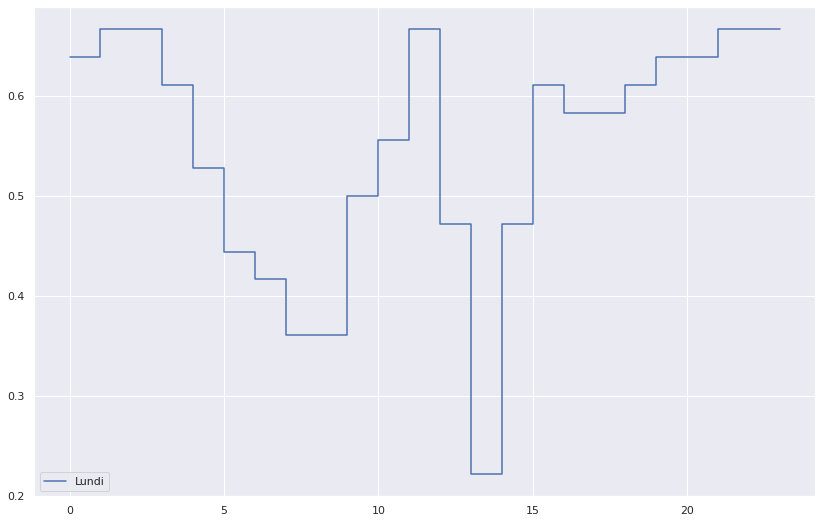

In [ ]:
station_code = 13019 # Juste à côté d'ici ...
plt.figure(figsize=(14,9))
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']

for day in range(10, 11):
  data_sub_station = data.loc[(data['code'] == station_code) &
                              (data['day'] == day),
                              ['hour', 'availability']]
  data_sub_station = data_sub_station.sort_values('hour')
  data_sub_station.head()

  hours = np.asarray([[x, x+1] for x in range(23)]).flatten()
  avail = np.asarray([[data_sub_station.values[i, 1], data_sub_station.values[i, 1]] for i in range(23)]).flatten()

  plt.plot(hours, avail, label=days[day - 10])

plt.legend()
plt.show()

No handles with labels found to put in legend.


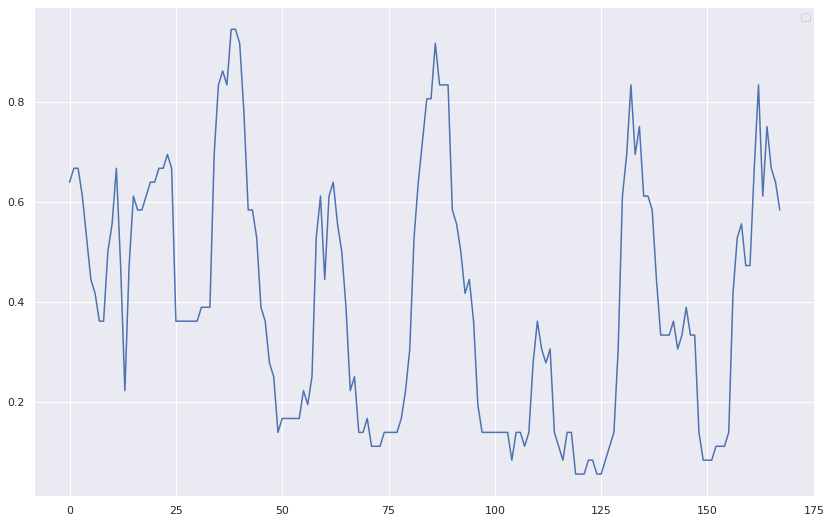

In [ ]:
station_code = 13019
plt.figure(figsize=(14,9))

avail = []

for day in range(7):
  data_sub_station = data.loc[(data['code'] == station_code) &
                              (data['day'] == 10 + day),
                              ['hour', 'availability']]
  data_sub_station = data_sub_station.sort_values('hour')

  avail = np.hstack((avail, data_sub_station.values[:, 1]))

plt.plot(range(24 * 7), avail)

plt.legend()
plt.show()